In [7]:
# Youtube Video Category
# Import Library yang dibutuhkan

!pip install joblib langdetect
!pip install emoji

from textwrap import wrap
import emoji
import joblib
import langdetect
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

# Set style untuk plot
plt.style.use("fivethirtyeight")

# Mengabaikan warning
warnings.filterwarnings("ignore")


In [10]:
# Data Loading
import pandas as pd

def get_category_dict(category_file):
  category = pd.read_json(category_file, orient="records")
  category = pd.DataFrame(category["items"].values.tolist())

  return {
      cat.id: cat.snippet.get("title")
      for cat in category.itertuples(index=False)}

In [11]:
def get_category_dict(category_file):
  category = pd.read_json(category_file, orient="records")
  category = pd.DataFrame(category["items"].values.tolist())

  return {
      cat.id: cat.snippet.get("title")
      for cat in category.itertuples(index=False)}

In [12]:
category_dict = get_category_dict('/content/category.json')

In [19]:
trending = pd.read_csv('/trending.csv', parse_dates=["publish_time", "trending_time"])

with pd.option_context("display.max_columns", None):
  display(trending.head())

,video_id,publish_time,channel_id,title,description,thumbnail_url,thumbnail_width,thumbnail_height,channel_name,tags,category_id,live_status,local_title,local_description,duration,dimension,definition,caption,license_status,allowed_region,blocked_region,view,like,dislike,favorite,comment,trending_time
0,NaN,2021-02-05 09:00:34+00:00,UCEf_Bc-KVd7onSeifS3py9g,aespa 에스파 'Forever (약속)' MV,"aespa's new single ""Forever"" is out!\nListen a...",NaN,NaN,NaN,SMTOWN,NaN,10,none,aespa 에스파 'Forever (약속)' MV,"aespa's new single ""Forever"" is out!\nListen a...",PT5M7S,2d,hd,True,True,NaN,NaN,7806846.0,857902.0,24078.0,0,94961.0,2021-02-07 05:46:51.832614+00:00
1,NaN,2021-02-04 15:54:08+00:00,UCYEa4_MC7OFjcWrO6SO-u8g,[FULL] Siapa di Balik Kudeta AHY? | Dua Sisi t...,"Jakarta, https://www.tvonenews.com - Ketua umu...",NaN,NaN,NaN,Indonesia Lawyers Club,"['tvone', 'tv one', 'tvonenews', 'indonesia la...",25,none,[FULL] Siapa di Balik Kudeta AHY? | Dua Sisi t...,"Jakarta, https://www.tvonenews.com - Ketua umu...",PT42M30S,2d,hd,False,True,NaN,NaN,885038.0,6765.0,1263.0,0,6365.0,2021-02-07 05:46:51.832649+00:00
2,NaN,2021-02-06 03:00:22+00:00,UCu12RxQjRQyh79YBYvEDkOg,CABRIOLET CHALLENGE: TANTANGAN MENGGODA (7/12),Road Party Season 2: Cabriolet Challenge\n\nEp...,NaN,NaN,NaN,Motomobi,"['MotoMobi', 'Mobil', 'motor', 'review', 'indo...",2,none,CABRIOLET CHALLENGE: TANTANGAN MENGGODA (7/12),Road Party Season 2: Cabriolet Challenge\n\nEp...,PT46M43S,2d,hd,False,True,NaN,NaN,889708.0,47895.0,532.0,0,8785.0,2021-02-07 05:46:51.832664+00:00
3,NaN,2021-02-05 20:26:08+00:00,UCCuzDCoI3EUOo_nhCj4noSw,With Windah Basudara & Hans,Join this channel to get access to perks:\nhtt...,NaN,NaN,NaN,yb,NaN,20,none,With Windah Basudara & Hans,Join this channel to get access to perks:\nhtt...,PT45M59S,2d,hd,False,True,NaN,NaN,1006854.0,91973.0,3967.0,0,12957.0,2021-02-07 05:46:51.832678+00:00
4,NaN,2021-02-03 23:14:54+00:00,UC14UlmYlSNiQCBe9Eookf_A,🤯 LATE COMEBACK DRAMA! | HIGHLIGHTS | Granada ...,"With just two minutes to play, Barça looked to...",NaN,NaN,NaN,FC Barcelona,"['FC Barcelona', 'برشلونة،', 'Fútbol', 'FUTBOL...",17,none,🤯 LATE COMEBACK DRAMA! | HIGHLIGHTS | Granada ...,"With just two minutes to play, Barça looked to...",PT5M12S,2d,hd,False,True,NaN,NaN,6275035.0,218131.0,4289.0,0,12799.0,2021-02-07 05:46:51.832730+00:00


In [20]:
start_date = trending.trending_time.min()
end_date = trending.trending_time.max()

print(f"{start_date = }")
print(f"{end_date = }")

start_date = '2021-02-07 05:46:51.832614+00:00'
end_date = '2023-09-01 09:16:49.916211+00:00'


In [29]:
# Delete data dari bulan Februari - Juni

trending['trending_time'] = pd.to_datetime(trending['trending_time'], format='mixed', errors='coerce')
# The 'format='mixed'' argument allows pandas to infer the format for each element individually.
#The 'errors='coerce'' will set invalid values to NaT(Not a time).
filtered_trending = trending[trending.trending_time.dt.month >= 7 ]
start_date = filtered_trending.trending_time.min()
end_date = filtered_trending.trending_time.max()

print (f"{start_date =}")
print (f"{end_date=}")

start_date =Timestamp('2021-07-01 06:01:25.524449+0000', tz='UTC')
end_date=Timestamp('2023-09-01 09:16:49.916211+0000', tz='UTC')


In [30]:
num_videos = filtered_trending.shape[0]
print(f"{num_videos = }")

num_videos = 36337

num_videos = 81517


In [31]:
# Distribusi Missing Value

filtered_trending.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81517 entries, 21322 to 172346
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   video_id           49717 non-null  object             
 1   publish_time       81517 non-null  datetime64[ns, UTC]
 2   channel_id         81517 non-null  object             
 3   title              81517 non-null  object             
 4   description        78544 non-null  object             
 5   thumbnail_url      49717 non-null  object             
 6   thumbnail_width    49717 non-null  float64            
 7   thumbnail_height   49717 non-null  float64            
 8   channel_name       81517 non-null  object             
 9   tags               70149 non-null  object             
 10  category_id        81517 non-null  int64              
 11  live_status        81517 non-null  object             
 12  local_title        81517 non-null  object     

In [32]:
# Delete video dengan description kosong

filtered_trending.dropna(subset=["description"], inplace=True)

In [35]:
# Exploratory Data Analysis

trending_by_date = filtered_trending.groupby(
    filtered_trending.trending_time.dt.date
)
num_trending_per_day = trending_by_date.trending_time.count()
print("Number of videos in trending per day:", num_trending_per_day.unique())

Number of videos in trending per day: [195 196 197 198 194 193 192 191 190 188 187 185 189 186 184 183 132 182
 181 179 176 172 155 144 149 148 141 140 131 129 145 167 163 157 156 175
 169 199 200 381]


In [48]:
# Trending Duration

trending_duration = filtered_trending.groupby("title").agg(
    trending_duration=pd.NamedAgg(column="trending_time", aggfunc="count"),
    trending_start_date=pd.NamedAgg(column="trending_time", aggfunc="min"),
    trending_last_date=pd.NamedAgg(column="trending_time", aggfunc="max")
).sort_values("trending_duration", ascending=False).reset_index()

trending_duration.head(10)

,title,trending_duration,trending_start_date,trending_last_date
0,Toleransi antar tetangga di Korea🇰🇷.. 🤦🏻‍♂️,37,2022-07-02 06:01:31.621606+00:00,2022-08-07 06:01:00.607651+00:00
1,"JEJE PENGHUNI STASIUN DUKUH ATAS, PERNAH CABUT...",37,2022-07-02 06:01:31.621150+00:00,2022-08-07 06:01:00.607537+00:00
2,"NEGO 1 GEROBAK SHAWARMA VIRAL DI TIKTOK, SAMPE...",36,2022-07-08 06:01:39.900318+00:00,2022-08-12 06:01:33.892049+00:00
3,OPW ARES Sudah Tamat,35,2022-07-02 06:01:31.621296+00:00,2022-08-05 06:02:43.644196+00:00
4,"Tantangin VYN Pake Franco, 1 Kali Kena Hook Da...",35,2022-07-01 06:01:38.284040+00:00,2022-08-04 06:02:04.519603+00:00
5,SINGAPORE STREET FOOD #08,35,2022-07-02 06:01:31.621620+00:00,2022-08-06 06:02:02.694750+00:00
6,Kok di Indonesia ada penjual Rawon yg lebih pi...,34,2022-07-02 06:01:31.621592+00:00,2022-08-04 06:02:04.519738+00:00
7,SELAMAT LEBARAN GUYS!!!,33,2022-07-11 06:00:59.413948+00:00,2022-08-12 06:01:33.891919+00:00
8,"HANYA FARIDA NURHAN, MUKBANG MIE GACOAN LEVEL ...",32,2022-07-11 06:00:59.414152+00:00,2022-08-11 06:01:46.801212+00:00
9,BORONG ISI KULKAS SAMA BABY SHARK!!!,32,2022-07-02 06:01:31.621266+00:00,2022-08-02 06:14:40.735514+00:00


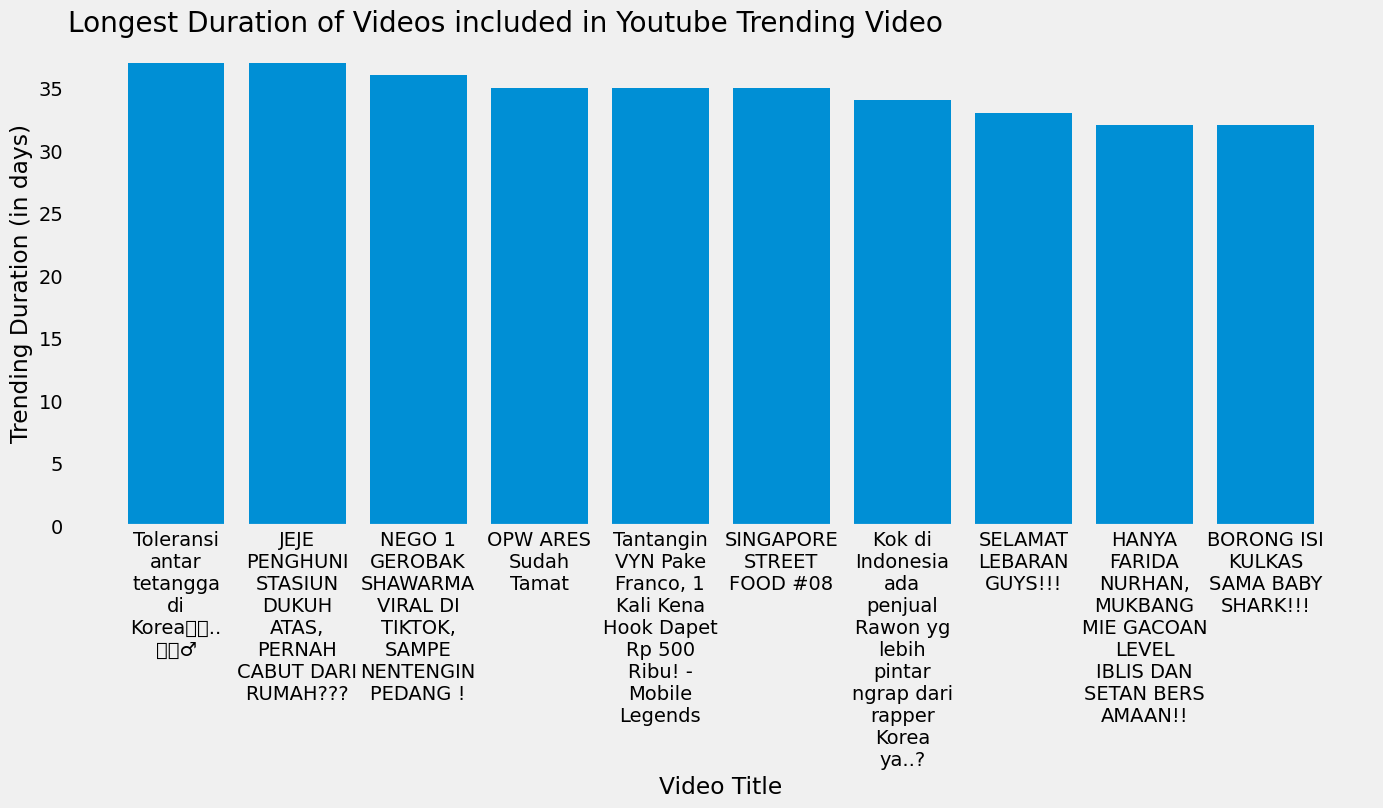

In [37]:
# Visualisasi data trending dengan chart bar

plt.figure(figsize=(15, 6))
plt.bar(
    trending_duration.title[:10].apply(lambda title: "\n".join(wrap(title, width=10))),
    trending_duration.trending_duration[:10]
)
plt.title("Longest Duration of Videos included in Youtube Trending Video", loc="left")
plt.xlabel("Video Title")
plt.ylabel("Trending Duration (in days)")
plt.grid(False)
plt.show()

In [38]:
# Most Viewed, Liked and Disliked Video

trending_by_title = filtered_trending.groupby("title")
trending_rewind = trending_by_title[["view", "like", "dislike"]].agg(["min", "max", "mean", "sum"])
trending_rewind

view             \
                                                          min        max   
title                                                                      
"Awalnya Diserang Bertubi tubi" Lihatlah Bagaim...   101823.0   121044.0   
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...  2280620.0  2637486.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...    72434.0   116310.0   
"GUE JADI TAU ISI HATI WARISO SELAMA INI..."        1798947.0  2064042.0   
"Grebek rumah harris vriza, dan percintaannya d...    68879.0   163773.0   
...                                                       ...        ...   
🥘Yuk! Kita coba in! Let’s eat | WayV’s ONE-DAY ...   148668.0   680210.0   
🥰 New Gadgets & Versatile Utensils For Home # 2...   330156.0  7334655.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...   278942.0  1212522.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...   320084.0  1097903.0   
🩸괴담회에 어서오세요🩸: 첫 번째 이야기 | WELCOME TO NCT’S HORRO...  1423178.0  2966798.0   

                                                                              \
                                                            mean         sum   
title                                                                          
"Awalnya Diserang Bertubi tubi" Lihatlah Bagaim...  1.114335e+05    222867.0   
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...  2.459053e+06   4918106.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...  9.390625e+04    375625.0   
"GUE JADI TAU ISI HATI WARISO SELAMA INI..."        1.981122e+06  19811225.0   
"Grebek rumah harris vriza, dan percintaannya d...  1.267565e+05    760539.0   
...                                                          ...         ...   
🥘Yuk! Kita coba in! Let’s eat | WayV’s ONE-DAY ...  5.519997e+05   8831995.0   
🥰 New Gadgets & Versatile Utensils For Home # 2...  3.414214e+06  34142143.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...  7.948737e+05   5564116.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...  7.562497e+05   4537498.0   
🩸괴담회에 어서오세요🩸: 첫 번째 이야기 | WELCOME TO NCT’S HORRO...  2.629831e+06  36817634.0   

                                                        like            \
                                                         min       max   
title                                                                    
"Awalnya Diserang Bertubi tubi" Lihatlah Bagaim...    1336.0    1456.0   
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...   93348.0  101207.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...     990.0    1432.0   
"GUE JADI TAU ISI HATI WARISO SELAMA INI..."         41528.0   44699.0   
"Grebek rumah harris vriza, dan percintaannya d...    5529.0    8714.0   
...                                                      ...       ...   
🥘Yuk! Kita coba in! Let’s eat | WayV’s ONE-DAY ...   39847.0  101922.0   
🥰 New Gadgets & Versatile Utensils For Home # 2...    2822.0   58066.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...    2790.0   10212.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...    3025.0    8759.0   
🩸괴담회에 어서오세요🩸: 첫 번째 이야기 | WELCOME TO NCT’S HORRO...  316849.0  457809.0   

                                                                              \
                                                             mean        sum   
title                                                                          
"Awalnya Diserang Bertubi tubi" Lihatlah Bagaim...    1396.000000     2792.0   
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...   97277.500000   194555.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...    1228.500000     4914.0   
"GUE JADI TAU ISI HATI WARISO SELAMA INI..."         43795.800000   437958.0   
"Grebek rumah harris vriza, dan percintaannya d...    7486.833333    44921.0   
...                                                           ...        ...   
🥘Yuk! Kita coba in! Let’s eat | WayV’s ONE-DAY ...   87227.125000  1395634.0   
🥰 New Gadgets & Versatile Utensils

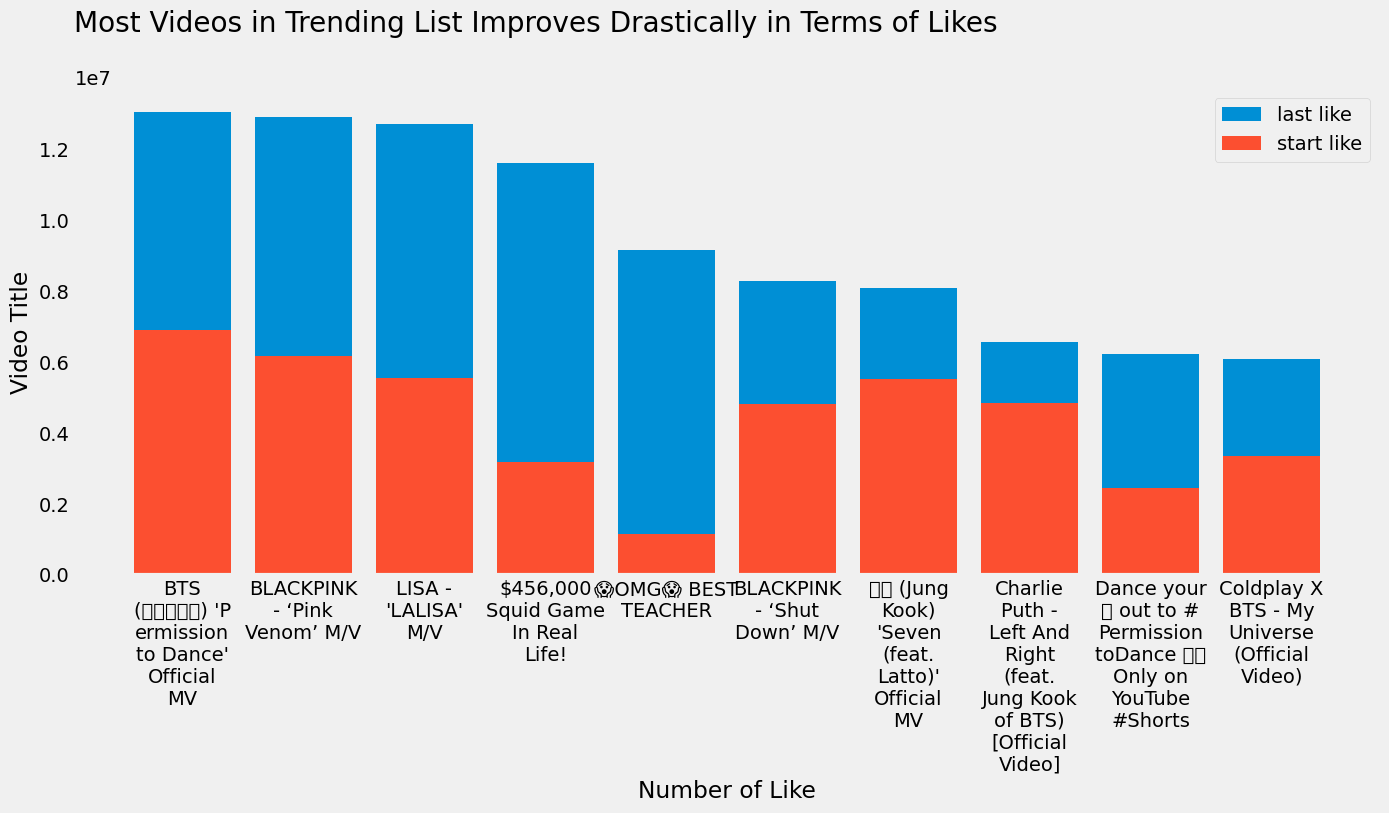

In [57]:
# Visualisasi Trending video teratas masing2

top_10_liked = trending_rewind["like"].sort_values("max", ascending=False).iloc[:10]

plt.figure(figsize=(15, 6))
plt.bar(
    top_10_liked.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_liked["max"],
    label="last like"
)
plt.bar(
    top_10_liked.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_liked["min"],
    label="start like",
)
plt.title("Most Videos in Trending List Improves Drastically in Terms of Likes", loc="left", y=1.1)
plt.xlabel("Number of Like")
plt.ylabel("Video Title")
plt.legend()
plt.grid(False)
plt.show()

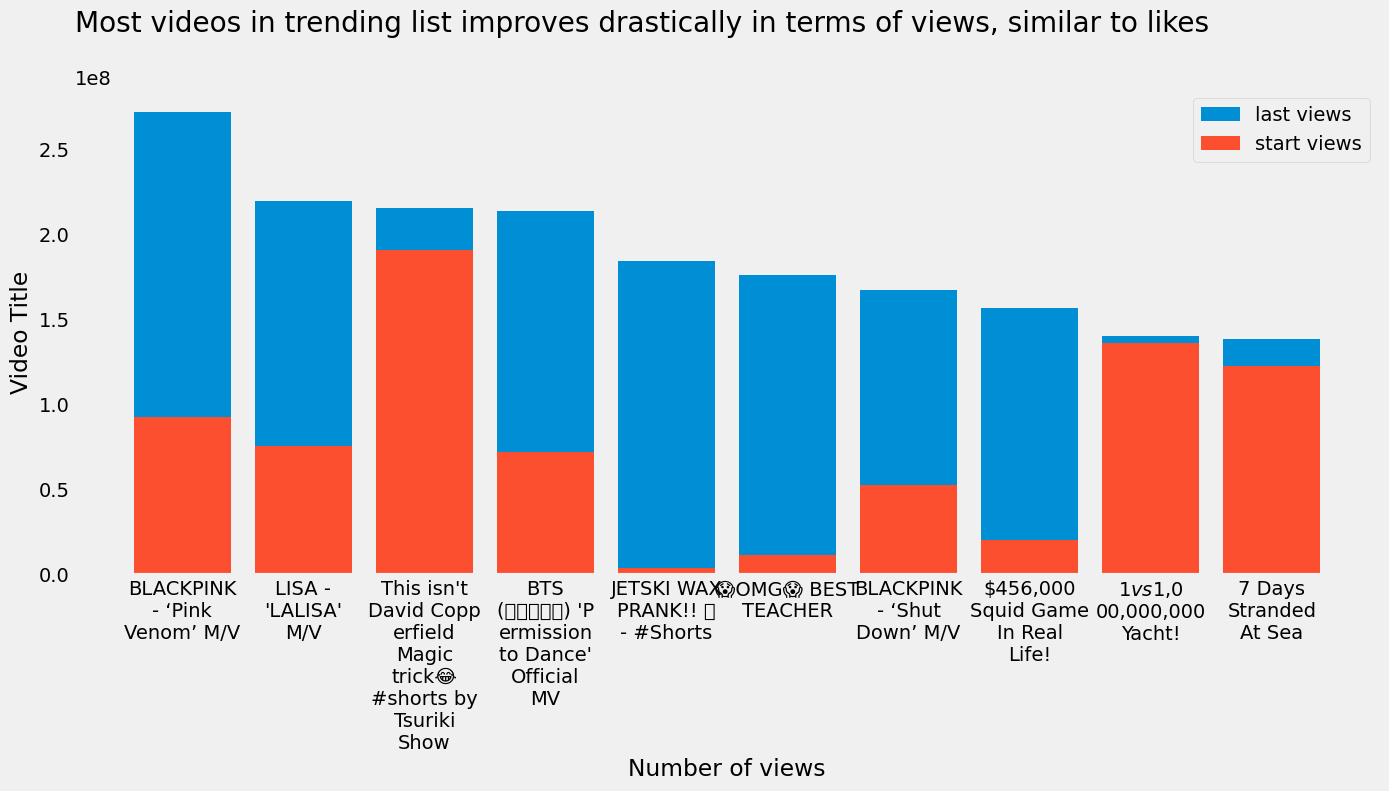

In [58]:
top_10_viewed = trending_rewind["view"].sort_values ("max", ascending=False).iloc[:10]

plt.figure(figsize=(15, 6))
plt.bar(
    top_10_viewed.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_viewed ["max"],
    label="last views"
)
plt.bar(
    top_10_viewed.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_viewed["min"],
    label="start views"
)
plt.title("Most videos in trending list improves drastically in terms of views, similar to likes", loc="left", y=1.1)
plt.xlabel("Number of views")
plt.ylabel("Video Title")
plt.legend()
plt.grid(False)
plt.show()

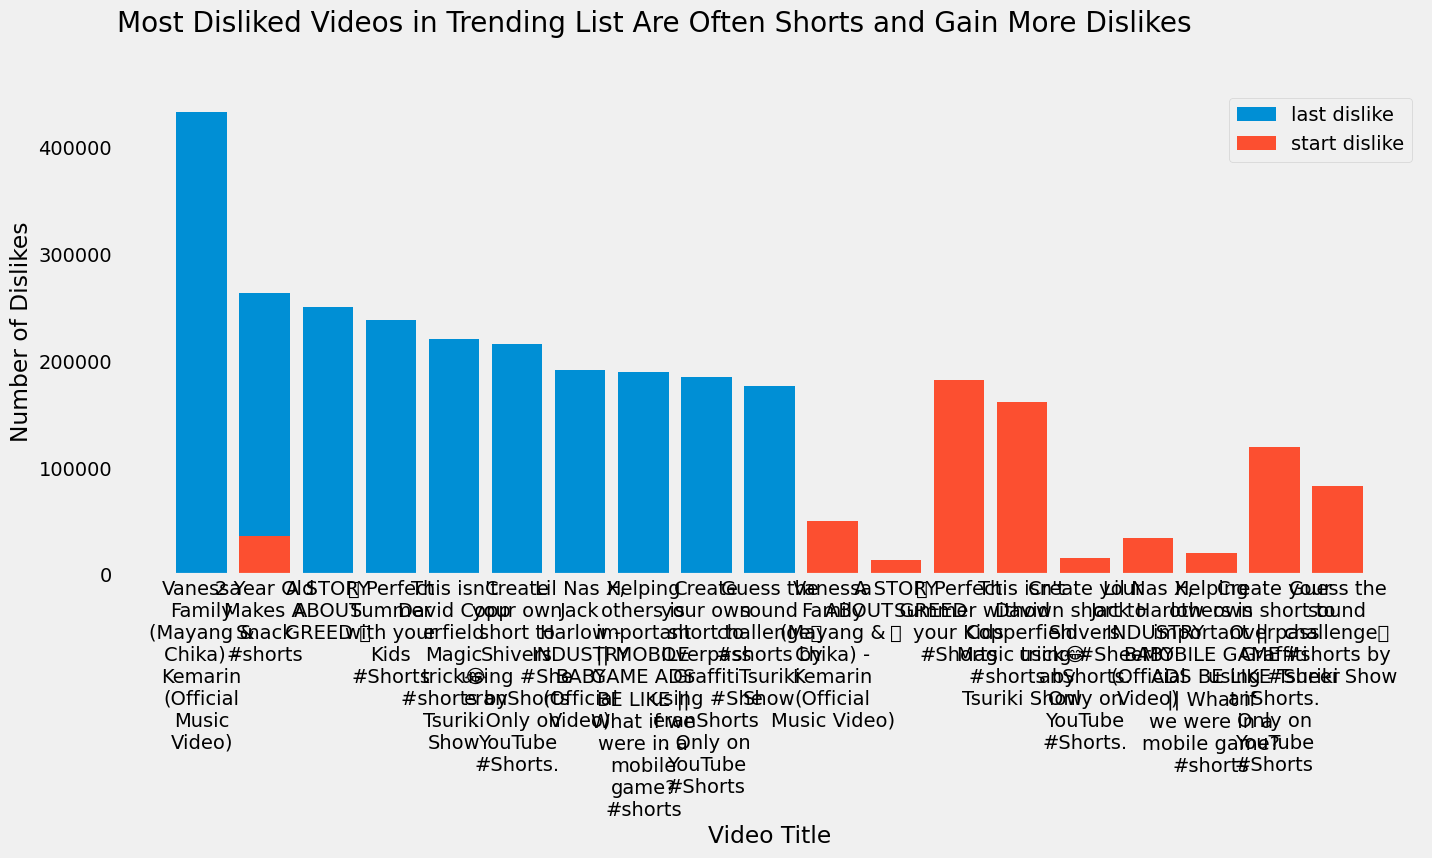

In [59]:
top_10_disliked = trending_rewind["dislike"].sort_values("max", ascending=False).iloc[:10]
plt.figure(figsize=(15, 6))

plt.bar(
    top_10_disliked.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_disliked["max"],
    label="last dislike"
)
plt.bar(
    top_10_disliked.index.to_series().apply(lambda title: "\n".join(wrap(title, width=12))),
    top_10_disliked["min"],
    label="start dislike"
)

plt.title("Most Disliked Videos in Trending List Are Often Shorts and Gain More Dislikes", loc="left", y=1.1)
plt.ylabel("Number of Dislikes")
plt.xlabel("Video Title")
plt.legend()
plt.grid(False)
plt.show()

In [60]:
# Data Preparation

!pip install langdetect

In [61]:
sample = filtered_trending.sample(10, random_state=11)
sample[["title", "description"]]

,title,description
46742,CHALLENGE MAKAN PALING HORROR! #MakanOnlineCha...,MAKAN ONLINE CHALLENGE by MAKAN ONLINE\n\nSpon...
109477,The Pangeran and Justin Show: Badmin Son Hat-t...,Son Heung-min bikin langsung bikin hattrick se...
123855,Match Highlights Persik 0 - 3 PERSIB | Pekan 1...,PERSIB meraih kemenangan 3-0 atas Persik Kedir...
32257,MASTERCHEF INDONESIA - JADI PESERTA PERTAMA YG...,Galeri 19 | Part 7\n==========================...
29932,(COVER) Andekhi Anjaani - Putri Isnari feat Ri...,(COVER)Andekhi Anjaani - Putri Isnari feat Rid...
95923,Mira Putri ft Ageng Music - TIARA (Official Li...,Official Live Music : Mira Putri ft Ageng Musi...
121702,JKT48 New Era Special Performance Video – Eure...,Eureka Milik Kita hadir dengan konsep yang ber...
43837,RACHEL VENNYA DI BACK UP SIAPA⁉️ KITA BONGKAR ...,#rachelvennya #covid #podcast
115628,KIKY SAPUTRI DILAMAR ANAK PEJABAT,Silakan komen di bawah 🖤 Kalian mau aku buat k...
46159,Yeni Inka - Top Topan (Official Music Video AN...,Title: Top Topan\nArtist: Yeni Inka\nSongwrite...


In [63]:
# Merubah title dan descripsi video menjadi Lowercase

sample["title_lang"] = sample.title.apply(lambda title: langdetect.detect(title.lower()))
sample["desc_lang"] = sample.description.apply(lambda desc: langdetect.detect(desc.lower()))

In [64]:
with pd.option_context("display.max_colwidth", 100):
  display(sample[["title", "title_lang", "description", "desc_lang"]])

,title,title_lang,description,desc_lang
46742,CHALLENGE MAKAN PALING HORROR! #MakanOnlineChallenge (2/8),tl,MAKAN ONLINE CHALLENGE by MAKAN ONLINE\n\nSponsored by MS Slim by Ms Glow\n\nCHALLENGE FOOD VLOG...,en
109477,"The Pangeran and Justin Show: Badmin Son Hat-trick, Koci Gak Terkesan!",en,Son Heung-min bikin langsung bikin hattrick setelah gak mencetak gol di 8 pertandingan. Tapi Coa...,id
123855,Match Highlights Persik 0 - 3 PERSIB | Pekan 12 Liga 1 2022,id,"PERSIB meraih kemenangan 3-0 atas Persik Kediri pada pekan ke-12 Liga 1 di Stadion Manajan, Solo...",id
32257,MASTERCHEF INDONESIA - JADI PESERTA PERTAMA YG DIPANGGIL LORD ADI PANIK LAH MASA ENGGAK! | Galer...,id,Galeri 19 | Part 7\n=======================================\nPANIK GAK? PANIK GAK? PANIKLAH MASA...,id
29932,(COVER) Andekhi Anjaani - Putri Isnari feat Ridwan,id,"(COVER)Andekhi Anjaani - Putri Isnari feat Ridwan\n\nDalam proses pembuatan video ini, seluruh t...",id
95923,Mira Putri ft Ageng Music - TIARA (Official Live Music) Jika kau bertemu aku begini,id,Official Live Music : Mira Putri ft Ageng Music - Tiara\nSubscribe Global Musik Era Digital\nhtt...,id
121702,JKT48 New Era Special Performance Video – Eureka Milik Kita,sl,Eureka Milik Kita hadir dengan konsep yang berbeda! Kali ini JKT48 Zee berkolaborasi dengan para...,id
43837,RACHEL VENNYA DI BACK UP SIAPA⁉️ KITA BONGKAR COBA‼️ Prof ZUBAIRI - dr TIRTA - Corbuzier Podcast,id,#rachelvennya #covid #podcast,en
115628,KIKY SAPUTRI DILAMAR ANAK PEJABAT,id,Silakan komen di bawah 🖤 Kalian mau aku buat konten apa lagi?\n\nTHANKYOU FOR 🤍\n\n- WO : @savet...,en
46159,Yeni Inka - Top Topan (Official Music Video ANEKA SAFARI) Kulo pun angkat tangan | MIQBAL GA,id,Title: Top Topan\nArtist: Yeni Inka\nSongwriter: MIQBAL GA\n\nFollow juga kita disini yuk :\nTik...,id


In [65]:
# Membuat fungsi yang akan mendeteksi bahasa dari sebuah teks

def detect_language(text):
  """Detect language of the 'text'."""
  try:
    lang = langdetect.detect(text)
    return lang
  except:
    return

In [66]:
def detect_language(text):
  """Detect language of the 'text'."""
  try:
    lang = langdetect.detect(text)
    return lang
  except:
    return

In [67]:
filtered_trending["title_lang"] = filtered_trending["title"].apply(detect_language)
filtered_trending["desc_lang"] = filtered_trending["description"].apply(detect_language)

In [68]:
filtered_trending[["title", "title_lang", "description", "desc_lang"]]

,title,title_lang,description,desc_lang
21322,NCT DREAM 엔시티 드림 'Hello Future' MV,it,"NCT DREAM's 1st Album Repackage ""Hello Future""...",en
21323,PART 3 // SUTRISNO DAN ENDANG BAHAGIA,de,Find me on sosial media :\n\nInstagram : https...,en
21324,This isn't David Copperfield Magic trick😂 #sho...,en,Thank you for watching.\nSubscribe to Tsuriki ...,en
21325,Rizky Billar - Pemimpinmu | Official Music Video,it,Rizky Billar - Pemimpinmu | Official Music Vid...,id
21326,Ini Pengakuan Pengemudi Pajero usai Rusak dan ...,id,Polisi menangkap pengemudi SUV yang merusak da...,id
...,...,...,...,...
172342,IBT 167: A IKY BONGKAR GEBETAN BARU SULE?! TEB...,en,#sule #njan #inibukantalkshow #rizkyfebian #pu...,id
172343,Sangkolan 1 | short movie madura ( SUB INDONES...,id,Welcome to @Akeloy Production \nKali ini kami...,id
172344,BONGKAR RUMAH MASA KECILKU DI DESA WAJOK HILIR...,de,#desa #pulangkampung #yennydichina #indonesi...,id
172345,Apakah Ini KODE KERAS Zidan ‼️ Merayu Mbak Yay...,id,"KONTAK PERSON / ADMIN (KHUSUS ENDORSE, JOB, EV...",id


In [69]:
indo_trending = filtered_trending.loc[
    (filtered_trending.title_lang == "id") | (filtered_trending.desc_lang == "id")
]

with pd.option_context("display.max_columns", None):
  display(indo_trending.sample(10))

,video_id,publish_time,channel_id,title,description,thumbnail_url,thumbnail_width,thumbnail_height,channel_name,tags,category_id,live_status,local_title,local_description,duration,dimension,definition,caption,license_status,allowed_region,blocked_region,view,like,dislike,favorite,comment,trending_time,title_lang,desc_lang
117613,x3cnYSPMefQ,2022-11-09 07:35:31+00:00,UC_vsErcsq56hOscPHkG-aVw,TERCYDUK! Novia Lihat Tammy Bermalam di Rumah ...,Saksikan siaran digital SCTV di channel 24 UHF...,https://i.ytimg.com/vi/x3cnYSPMefQ/hqdefault.jpg,480.0,360.0,SCTV,"['sctv', 'indonesia', 'movies', 'sinetron sctv...",24,none,TERCYDUK! Novia Lihat Tammy Bermalam di Rumah ...,Saksikan siaran digital SCTV di channel 24 UHF...,PT4M49S,2d,hd,False,True,NaN,NaN,253982.0,2252.0,NaN,0,196.0,2022-11-14 06:02:19.200848+00:00,id,id
118165,gSvimJmxscw,2022-11-16 13:00:28+00:00,UCzTsWuCdVP_vehWyGwPcS3Q,Bubun Berbuat Nekad Datang Kerumah Bang Edi - ...,Bubun nekad untuk dateng kerumah bang Edi send...,https://i.ytimg.com/vi/gSvimJmxscw/hqdefault.jpg,480.0,360.0,RCTI - LAYAR DRAMA INDONESIA,"['Sinetron', 'Sinetron RCTI', 'Full Episode', ...",24,none,Bubun Berbuat Nekad Datang Kerumah Bang Edi - ...,Bubun nekad untuk dateng kerumah bang Edi send...,PT10M22S,2d,hd,False,False,NaN,NaN,362657.0,4717.0,NaN,0,275.0,2022-11-17 06:02:00.004648+00:00,id,id
105941,RCYHpwtvqrE,2022-08-26 16:06:15+00:00,UCkJCKbnbDEKAJAJBY_XcO0A,Rumah Singgah,Provided to YouTube by IIP-DDS\n\nRumah Singga...,https://i.ytimg.com/vi/RCYHpwtvqrE/hqdefault.jpg,480.0,360.0,Fabio Asher - Topic,"['Fabio Asher', 'Rumah Singgah']",10,none,Rumah Singgah,Provided to YouTube by IIP-DDS\n\nRumah Singga...,PT4M7S,2d,hd,False,True,"['AE', 'AR', 'AS', 'AT', 'AU', 'AW', 'BA', 'BE...",NaN,1260269.0,7945.0,NaN,0,0.0,2022-09-16 06:02:42.280687+00:00,id,en
36698,NaN,2021-09-11 03:06:05+00:00,UCZHNp91QML_yAExCY8lduVw,[BEHIND THE SCENES] SAHABAT TAK AKAN PERGI ||B...,Yeay ! Akhirnya Music Video Anneth bareng Onyo...,NaN,NaN,NaN,Anneth Delliecia,"['Anneth Delliecia Nasution', 'anneth', 'delli...",10,none,[BEHIND THE SCENES] SAHABAT TAK AKAN PERGI ||B...,Yeay ! Akhirnya Music Video Anneth bareng Onyo...,PT18M32S,2d,hd,False,True,NaN,NaN,177811.0,23606.0,157.0,0,1008.0,2021-09-15 06:16:56.384622+00:00,en,id
119445,y9PCdOux1QI,2022-11-17 12:02:41+00:00,UCirWugW5e03u3DUGA87s58A,Pertama Kali NGAMBEK Karena TINGKAH VIOR SELAL...,▶ Top up semua voucher Game Teraman Terpercaya...,https://i.ytimg.com/vi/y9PCdOux1QI/hqdefault.jpg,480.0,360.0,Oura Gaming,"['evos oura', 'youtube gaming', 'handcam oura'...",20,none,Pertama Kali NGAMBEK Karena TINGKAH VIOR SELAL...,▶ Top up semua voucher Game Teraman Terpercaya...,PT16M23S,2d,hd,False,True,NaN,NaN,333279.0,7950.0,NaN,0,391.0,2022-11-23 06:01:32.474533+00:00,id,id
96394,KrTNKEcZwoA,2022-07-25 08:00:05+00:00,UCzxLFG_G8UwCB4hKrOnSWDg,TANJUNG MAS NINGGAL JANJI - SASYA ARKHISNA (OF...,Download and Stream : SEGERA\nTANJUNG MAS NING...,https://i.ytimg.com/vi/KrTNKEcZwoA/hqdefault.jpg,480.0,360.0,SEMBADA MUSIC,"['sembada music', 'sembada musik terbaru', 'se...",10,none,TANJUNG MAS NINGGAL JANJI - SASYA ARKHISNA (OF...,Download and Stream : SEGERA\nTANJUNG MAS NING...,PT5M11S,2d,hd,True,True,NaN,NaN,90356.0,1428.0,NaN,0,129.0,2022-07-30 06:02:45.467908+00:00,en,id
26940,NaN,2021-07-28 09:44:44+00:00,UCSihM0hSwFLMTjQl_INmMZg,EYBEL JATUH DARI SEPEDA !! Lutut Luka Di Obati...,Drama eybel jatuh dari sepeda lutut sampai luk...,NaN,NaN,NaN,eybel channel,"['drama', 'eybel jatuh', 'jatuh dari sepeda', ...",24,none,EYBEL JATUH DARI SEPEDA !! Lutut Luka Di Obati...,Drama eybel jatuh dari sepeda lutut sampai luk...,PT6M46S,2d,hd,False,True,NaN,NaN,253956.0,1704.0,529.0,0,105.0,2021-07-29 06:00:56.663352+00:00,de,id
169706,YHHsfnItLgA,2023-08-02 09:00:12+00:00,UCNlU3oSU8UnJ_V9uMB-cPOg,NOAH - Semua Tentang Kita (OST. Cinta Tanpa Ka...,"Terima kasih, NOAH\nTerima kasih Sahabat\n\n11...",https://i.ytimg.com/vi/YHHsfnItLgA/hqdefault.jpg,480.0,360.0,Musica Studios,"['Musica', ""Studio's"", 'music

In [70]:
indo_trending = filtered_trending.loc[
    (filtered_trending.title_lang == "id") | (filtered_trending.desc_lang == "id")
]

with pd.option_context("display.max_columns", None):
  display(indo_trending.sample(10))

,video_id,publish_time,channel_id,title,description,thumbnail_url,thumbnail_width,thumbnail_height,channel_name,tags,category_id,live_status,local_title,local_description,duration,dimension,definition,caption,license_status,allowed_region,blocked_region,view,like,dislike,favorite,comment,trending_time,title_lang,desc_lang
44069,NaN,2021-10-17 13:58:19+00:00,UCkuwyW3QBFlKW60R6DDkZCw,Kenal Pak Bambang ga?? #kemananich,QG - Her (Official Visualizer)\nhttps://youtu....,NaN,NaN,NaN,Qorygore,"['Qorygore', 'new song qorygore', 'qorygore pi...",20,none,Kenal Pak Bambang ga?? #kemananich,QG - Her (Official Visualizer)\nhttps://youtu....,PT38M27S,2d,hd,False,True,NaN,NaN,604243.0,33768.0,415.0,0,2245.0,2021-10-22 06:16:55.644316+00:00,id,en
53674,pPhRY1cGO3w,2021-12-10 14:59:24+00:00,UCkB_AwGXxPAKdahxGHpeC4Q,[ID] PMGC 2021 League East | Super Weekend 2 D...,"""20 Tim terbaik dari East akan bertarung habis...",https://i.ytimg.com/vi/pPhRY1cGO3w/hqdefault.jpg,480.0,360.0,PUBG MOBILE Indonesia,"['pubg', 'pubgmobile', 'pubg mobile', 'pubg mo...",20,none,[ID] PMGC 2021 League East | Super Weekend 2 D...,"""20 Tim terbaik dari East akan bertarung habis...",PT3H50M46S,2d,hd,False,False,NaN,NaN,1655451.0,36424.0,589.0,0,246.0,2021-12-11 06:00:53.170218+00:00,en,id
166498,FeA-ngSzw8k,2023-07-06 05:01:08+00:00,UC2EA8X3TaqfF7fRwOI580kw,MELIHAT SNOWEE UNTUK TERAKHIR KALINYA..,Untuk lihat tingkah lucu anabul kesayangan kit...,https://i.ytimg.com/vi/FeA-ngSzw8k/hqdefault.jpg,480.0,360.0,The Golden Family,"['bima', 'bimaaryo', 'beemz', 'beemzaryo', 'sn...",15,none,MELIHAT SNOWEE UNTUK TERAKHIR KALINYA..,Untuk lihat tingkah lucu anabul kesayangan kit...,PT27M30S,2d,hd,False,True,NaN,NaN,606122.0,24036.0,NaN,0,2982.0,2023-07-19 06:01:23.836958+00:00,en,id
35628,NaN,2021-08-29 10:00:10+00:00,UC-S7cyZCojMeVopBkH6yNEw,ANDAI PONSEL JADI MANUSIA || HP-ku Sahabatku! ...,"Sekarang ini, ponsel ada di mana-mana.\nDan ad...",NaN,NaN,NaN,123 GO! CHALLENGE Indonesian,"['123 go', '123 go challenge', '123go', '123go...",26,none,ANDAI PONSEL JADI MANUSIA || HP-ku Sahabatku! ...,"Sekarang ini, ponsel ada di mana-mana.\nDan ad...",PT9M15S,2d,hd,False,True,NaN,NaN,1439921.0,12144.0,2130.0,0,379.0,2021-09-10 06:01:01.490970+00:00,id,id
27562,NaN,2021-07-26 11:07:22+00:00,UCGN9JsnkvK05v2lnTI_-uGA,China Dilanda Topan In-Fa Bandara & Stasiun Di...,"Awas! Jangan Klik Link Ini, Atau Uang Kamu Dir...",NaN,NaN,NaN,CNBC Indonesia,"['CNBC Indonesia', 'ekonomi', 'bisnis', 'indon...",22,none,China Dilanda Topan In-Fa Bandara & Stasiun Di...,"Awas! Jangan Klik Link Ini, Atau Uang Kamu Dir...",PT1M40S,2d,hd,False,True,NaN,NaN,604644.0,4601.0,252.0,0,2978.0,2021-08-01 06:00:51.096254+00:00,id,id
95225,AMsFgTrJscA,2022-06-22 06:00:05+00:00,UC5vz17NqPNmW8g0u1M_l90A,All New Range Rover 2022 | First Impression | ...,Range Rover mematenkan 125 item untuk teknolog...,https://i.ytimg.com/vi/AMsFgTrJscA/hqdefault.jpg,480.0,360.0,Oto Driver,"['OtoDriver', 'range rover', 'range rover 2022...",2,none,All New Range Rover 2022 | First Impression | ...,Range Rover mematenkan 125 item untuk teknolog...,PT27M32S,2d,hd,False,True,NaN,NaN,560033.0,9514.0,NaN,0,770.0,2022-07-22 06:01:25.365353+00:00,en,id
118030,h5ksUBjyEIE,2022-11-05 12:00:21+00:00,UCTJDdO9klWGpTekswnXreGQ,SpongeBob | 50 MENIT Squidward dan Ny. Puff ya...,Siapa yang lebih kesal dengan SpongeBob dan Pa...,https://i.ytimg.com/vi/h5ksUBjyEIE/hqdefault.jpg,480.0,360.0,Nickelodeon Bahasa,"['nickelodeon', 'Indonesia', 'bahasa', 'nick',...",1,none,SpongeBob | 50 MENIT Squidward dan Ny. Puff ya...,Siapa yang lebih kesal dengan SpongeBob dan Pa...,PT51M2S,2d,hd,False,True,NaN,NaN,1474280.0,12680.0,NaN,0,0.0,2022-11-16 06:02:10.849466+00:00,id,id
108044,XtFsjwnfGjk,2022-09-19 11:30:13+00:00,UCaKLg1ELiX0zTJ6Je3c5esA,JEMPUT AMEENA dirumah om RAUL LEMOS MIMI. ATTA...,"Instagram : @attahalilintar , @aurelie.hermans...",https://i.ytimg.com/vi/XtFsjwnfGjk/hqdefault.jpg,480.0,360.0,AH,NaN,24,none,JEMPUT AMEENA dirumah om RAUL LEMOS MIMI. ATTA...,"Instag

In [71]:
# Feature Extraction

data = indo_trending[["title", "description", "category_id"]].reset_index(drop=True)
data

,title,description,category_id
0,Rizky Billar - Pemimpinmu | Official Music Video,Rizky Billar - Pemimpinmu | Official Music Vid...,10
1,Ini Pengakuan Pengemudi Pajero usai Rusak dan ...,Polisi menangkap pengemudi SUV yang merusak da...,25
2,Aksi Demo Tolak Kedatangan Jokowi di Kendari B...,Tanggal Tayang: 30/06/2021\n\nProgram berita h...,25
3,"PERTAMA KALI LIAT SAPI SEGEDE GINI, DINAIKIN D...",Assalamualaikum gaeess..! sudah nonton video s...,15
4,PODKESMAS SAMPAI GA NYAMAN DIBAHAS DISINI - To...,Talk show malam yang akan memberikan informasi...,24
...,...,...,...
49172,IBT 167: A IKY BONGKAR GEBETAN BARU SULE?! TEB...,#sule #njan #inibukantalkshow #rizkyfebian #pu...,24
49173,Sangkolan 1 | short movie madura ( SUB INDONES...,Welcome to @Akeloy Production \nKali ini kami...,24
49174,BONGKAR RUMAH MASA KECILKU DI DESA WAJOK HILIR...,#desa #pulangkampung #yennydichina #indonesi...,22
49175,Apakah Ini KODE KERAS Zidan ‼️ Merayu Mbak Yay...,"KONTAK PERSON / ADMIN (KHUSUS ENDORSE, JOB, EV...",10


In [72]:
# Duplicates

data.drop_duplicates(subset="title", inplace=True)

In [73]:
data.reset_index(drop=True, inplace=True)
data.shape

(7444, 3)

In [74]:
# Feature Engineering

!pip install emoji

In [76]:
list_emoji = [e for e in emoji.EMOJI_DATA]

count = 0
for em in list_emoji:
  for title in data.title:
    if em in title:
      count += 1
print("How many titles use emoji?", count)

How many titles use emoji? 1018


In [77]:
def demojize(text):
  for em in list_emoji:
    if em in text:
      em_text = emoji.demojize(em)
      text = text.replace(em, " " + em_text + " ")
  return text

In [78]:
def demojize(text):
  for em in list_emoji:
    if em in text:
      em_text = emoji.demojize(em)
      text = text.replace(em, " " + em_text + " ")
  return text

In [79]:
data["title_emoji"] = data.title.apply(demojize)

In [80]:
title_with_emoji_idx = [
    idx for idx in range(len(data.title))
    for em in list_emoji
    if em in data.loc[idx, "title"]
]

In [81]:
with pd.option_context("display.max_colwidth", 100):
  display(data.loc[title_with_emoji_idx])

,title,description,category_id,title_emoji
34,Dari Jendela Smp : GREGETTT...Wih kelihatannya Wulan jadi primadona di SMA Merdeka Mandiri nih...❤,Saksikan #DariJendelaSMP Setiap Hari Pkl. 16.40 WIB hanya di @Surya Citra Televisi (SCTV) \n@sin...,24,Dari Jendela Smp : GREGETTT...Wih kelihatannya Wulan jadi primadona di SMA Merdeka Mandiri nih.....
78,BIKIN CEWEK TERPESONA 😍 Aksi Heroik Driver Muda Menolong Sopir Yang Kesulitan di Sitinjau Lauik,Aksi heroik driver muda membantu sopir minibus yang kesulitan di Sitinjau Lauik\n\ninstagram : h...,2,BIKIN CEWEK TERPESONA :smiling_face_with_heart-eyes: Aksi Heroik Driver Muda Menolong Sopir Ya...
79,15 MENIT MEMBAKAR LEMAK 1 Kg !!! 24 Jam TIMBANGAN TURUN ✅ ✅ ✅,"15 menit membakar lemak, ok ! siapa yg workout mengharapkan bisa membakar 1 kg lemak dalam 15 me...",26,15 MENIT MEMBAKAR LEMAK 1 Kg !!! 24 Jam TIMBANGAN TURUN :check_mark_button: :check_mark_butto...
149,"WHY‼️ SAYA DISOMASI, TOLOOONG...- Deddy Corbuzier Podcast","#somasi #odgj #podcast\nTEMAN TEMAN KONTEN CREATOR, JANGAN TAKUT BERKARYA SELAMA TUJUAN KALIAN B...",24,"WHY :double_exclamation_mark: SAYA DISOMASI, TOLOOONG...- Deddy Corbuzier Podcast"
149,"WHY‼️ SAYA DISOMASI, TOLOOONG...- Deddy Corbuzier Podcast","#somasi #odgj #podcast\nTEMAN TEMAN KONTEN CREATOR, JANGAN TAKUT BERKARYA SELAMA TUJUAN KALIAN B...",24,"WHY :double_exclamation_mark: SAYA DISOMASI, TOLOOONG...- Deddy Corbuzier Podcast"
...,...,...,...,...
7425,STANDUPFEST 2023 Extended Version dari The Founders 🥳🥳 - Lucu Terus Nih,"Host yang ada di video ini, Arie Kriting, mau bikin special show! Judulnya ILMU HITAM! Beli tike...",22,STANDUPFEST 2023 Extended Version dari The Founders :partying_face: :partying_face: - Lucu Te...
7426,BOY UDAH AJAK AYU TING-TING KE RUMAH BARU?😝,"Hai guys... welcome back in my youtube channel, kali ini aku mau ngajakin ngobrol BOY WILLIAM ni...",22,BOY UDAH AJAK AYU TING-TING KE RUMAH BARU? :squinting_face_with_tongue:
7428,ADA PACAR!?!?😉NGOBROL TENTANG GOSIP🇮🇩 SAMBIL MAKAN NASI PADANG SAMA KAK HARUKA,"HALO GUYS, OHAYOU KONNICHIWA KONBANWA!!! AKU YUSUKE!!! video kali ini, kita aku sama kak haruka ...",22,ADA PACAR!?!? :winking_face: NGOBROL TENTANG GOSIP :Indonesia: SAMBIL MAKAN NASI PADANG SAMA KA...
7428,ADA PACAR!?!?😉NGOBROL TENTANG GOSIP🇮🇩 SAMBIL MAKAN NASI PADANG SAMA KAK HARUKA,"HALO GUYS, OHAYOU KONNICHIWA KONBANWA!!! AKU YUSUKE!!! video kali ini, kita aku sama kak haruka ...",22,ADA PACAR!?!? :winking_face: NGOBROL TENTANG GOSIP :Indonesia: SAMBIL MAKAN NASI PADANG SAMA KA...


In [82]:
# Delete kolom title

data.drop(columns="title", inplace=True)

In [85]:
# EXPLORASI

desc_with_emoji_idx = [
    idx for idx in range(len(data.description))
    for em in list_emoji
    if em in data.loc[idx, "description"]
]

data["desc_emoji"] = data.description.apply(demojize)

with pd.option_context("display.max_colwidth", 100):
  display(data.loc[desc_with_emoji_idx])

,description,category_id,title_emoji,desc_emoji
0,Rizky Billar - Pemimpinmu | Official Music Video\n\nSurprise Untuk Dede Lesti :\nhttps://youtu.b...,10,Rizky Billar - Pemimpinmu | Official Music Video,Rizky Billar - Pemimpinmu | Official Music Video\n\nSurprise Untuk Dede Lesti :\nhttps://youtu.b...
8,#LestiBawaAkuKePenghulu #Lesti #MusicVideo #LiveAcoustic\n\nAura bahagia semakin terpancar denga...,10,Lesti - Bawa Aku Ke Penghulu | Live Acoustic Version,#LestiBawaAkuKePenghulu #Lesti #MusicVideo #LiveAcoustic\n\nAura bahagia semakin terpancar denga...
11,"Title: Sempurnakan Hariku \nArtist: Rey Mbayang\nComposser: Rey Mbayang, Trakast\nMusic Arranger...",10,Rey Mbayang - Sempurnakan Hariku (Official Music Video),"Title: Sempurnakan Hariku \nArtist: Rey Mbayang\nComposser: Rey Mbayang, Trakast\nMusic Arranger..."
12,Title: Apa Kabar Mantan\nArtist: Yeni Inka\nSongwriter: Yonanda NDX\n\nFollow juga kita disini y...,10,Yeni Inka - Apa Kabar Mantan (Official Music Video ANEKA SAFARI) | JOOX ORIGINAL,Title: Apa Kabar Mantan\nArtist: Yeni Inka\nSongwriter: Yonanda NDX\n\nFollow juga kita disini y...
12,Title: Apa Kabar Mantan\nArtist: Yeni Inka\nSongwriter: Yonanda NDX\n\nFollow juga kita disini y...,10,Yeni Inka - Apa Kabar Mantan (Official Music Video ANEKA SAFARI) | JOOX ORIGINAL,Title: Apa Kabar Mantan\nArtist: Yeni Inka\nSongwriter: Yonanda NDX\n\nFollow juga kita disini y...
...,...,...,...,...
7432,#sie_em\n\n__________________________________________________\nThanks for watching\n\nSUBSCRIBE ...,22,PASUKAN SENYAP Terancam PEGATON Ketua Kobra Part 4 - DRAMA ANIMASI,#sie_em\n\n__________________________________________________\nThanks for watching\n\nSUBSCRIBE ...
7434,#lunamaya #birthday \n\nPRODUK NIKITA SLIM/NIKITA MIRZANI SKINCARE BISA DIORDER DISINI YAA ⤵️⤵️\...,22,TERHARU !!BIRTHDAY PARTY LUNA MAYA,#lunamaya #birthday \n\nPRODUK NIKITA SLIM/NIKITA MIRZANI SKINCARE BISA DIORDER DISINI YAA :rig...
7434,#lunamaya #birthday \n\nPRODUK NIKITA SLIM/NIKITA MIRZANI SKINCARE BISA DIORDER DISINI YAA ⤵️⤵️\...,22,TERHARU !!BIRTHDAY PARTY LUNA MAYA,#lunamaya #birthday \n\nPRODUK NIKITA SLIM/NIKITA MIRZANI SKINCARE BISA DIORDER DISINI YAA :rig...
7443,Thank you for watching! Don't forget to like & comment!\n\n✧･ﾟ: *✧･ﾟ:* *:･ﾟ✧*:･ﾟ✧\n\n♱ Socials :...,20,Q&A sambil makan PADANG di Pasar Senen ft. Jessica Jane :drooling_face:,Thank you for watching! Don't forget to like & comment!\n\n✧･ﾟ: *✧･ﾟ:* *:･ﾟ✧*:･ﾟ✧\n\n♱ Socials :...


In [87]:
data.drop(columns="description", inplace=True)

In [88]:
data["all_text"] = data["title_emoji"] + " " + data["desc_emoji"]

In [89]:
# Text Processing

# data split
X_train, X_dev, y_train, y_dev = train_test_split(
    data["all_text"], data["category_id"],
    test_size=.2,
    stratify=data["category_id"],
    random_state=11
)
training_size = X_train.shape[0]
dev_size = X_dev.shape[0]

print(f"{training_size = }.. {dev_size = }")

# define vectorizer
vectorizer = TfidfVectorizer(
    min_df=.015,
    max_df=.7,
    ngram_range=(1, 1),
)

# generate tf-idf matrix
train_tfidf = vectorizer.fit_transform(X_train)
dev_tfidf = vectorizer.transform(X_dev)
print("Got train tf-idf with shape:", train_tfidf.shape)
print("Got dev tf-idf with shape:", dev_tfidf.shape)

# convert to dataframe
train_tfidf = pd.DataFrame(train_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
dev_tfidf = pd.DataFrame(dev_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

training_size = 5955.. dev_size = 1489
Got train tf-idf with shape: (5955, 930)
Got dev tf-idf with shape: (1489, 930)


In [90]:
with pd.option_context("display.max_columns", 100):
  display(train_tfidf.sample(5))

,00,000,01,03,04,06,07,08,09,10,100,11,12,13,14,15,16,17,18,19,1dvz1au,1gxqz9s,1st,20,2020,2021,2022,2023,21,22,23,24,26,28,2oukyag,2yfofxp,30,31,3ws0f48,45,62,about,academy,acara,ada,adalah,admin,agar,agustus,ahmad,...,up,update,updates,upload,us,user,utm_campaign,utm_medium,utm_source,v7,via,video,videonya,videos,vidio,viral,vlog,voc,vocal,vs,vt,wa,waktu,warga,watch,watching,web,website,welcome,wes,whatsapp,wib,with,withyoutube,wong,world,www,ya,yaa,yah,yaitu,yang,yen,yeni,yg,you,your,youtu,youtube,yuk
88,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.431173,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
5305,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.14571,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.116019,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.142848,0.0,0.0,0.087591,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.210055,0.0
5799,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
417,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.043668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.090357,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043236,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.090956,0.0,0.0,0.0,0.0,0.093551,0.0,0.0,0.0,0.000000,0.0,0.0,0.054531,0.0
2280,0.144856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.180194,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.054429,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.073412,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.08823,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.129518,0.0,0.000000,0.0,0.0,0.060239,0.0,0.0,0.0,0.0,0.061958,0.0,0.0,0.0,0.075242,0.0,0.0,0.072231,0.0


In [93]:
# Modeling
# Model Training & Evaluation

dict_models = {
    "logistic_regression": LogisticRegression(),
    "naive_bayes": MultinomialNB(),
    "svm": LinearSVC(random_state=11),
    "decision_tree": DecisionTreeClassifier(random_state=11),
    "random_forest": RandomForestClassifier(random_state=11)
}

In [95]:
for model in dict_models.values():
  print(f"-- {model.__class__.__name__}")
  model.fit(train_tfidf,y_train)
  y_pred = model.predict(dev_tfidf)
  print("Reports on dev set:", classification_report(y_dev, y_pred), sep="\n")

-- LogisticRegression
Reports on dev set:
              precision    recall  f1-score   support

           1       0.90      0.69      0.78        55
           2       1.00      0.70      0.82        46
          10       0.91      0.94      0.93       275
          15       1.00      0.57      0.73        14
          17       0.88      0.73      0.80        67
          19       1.00      0.62      0.77         8
          20       0.91      0.94      0.92       150
          22       0.74      0.65      0.69       152
          23       0.92      0.48      0.63        48
          24       0.76      0.91      0.83       484
          25       0.85      0.94      0.89       126
          26       1.00      0.05      0.10        20
          27       1.00      0.33      0.50        12
          28       1.00      0.70      0.82        20
          29       1.00      0.92      0.96        12

    accuracy                           0.84      1489
   macro avg       0.93      0.68     

In [96]:
# HYPERPARAMETER TUNING
# LINEAR SVC

svm_grid_search = GridSearchCV(
    dict_models["svm"],
    {"C": (10, 1, 1, .05, .01)},
)

svm_grid_search.fit(train_tfidf, y_train)
svm_pred_dev = svm_grid_search.predict(dev_tfidf)
print("Reports on train set:",
      classification_report(
          y_train,
          svm_grid_search.predict(train_tfidf)
      ), sep="\n")
print("Reports on dev set:", classification_report(y_dev, svm_pred_dev), sep="\n")

Reports on train set:
              precision    recall  f1-score   support

           1       0.97      0.96      0.97       222
           2       0.98      0.98      0.98       183
          10       0.96      0.99      0.97      1101
          15       0.91      0.94      0.93        54
          17       0.94      0.97      0.96       268
          19       1.00      0.88      0.94        34
          20       0.95      0.97      0.96       601
          22       0.93      0.86      0.89       606
          23       0.97      0.92      0.95       193
          24       0.93      0.93      0.93      1934
          25       0.95      0.98      0.97       505
          26       0.90      0.92      0.91        78
          27       0.96      0.92      0.94        49
          28       1.00      0.96      0.98        80
          29       1.00      0.96      0.98        47

    accuracy                           0.95      5955
   macro avg       0.96      0.94      0.95      5955
weig

In [98]:
# Define and execute GridSearchCV for RandomForest
random_forest_grid_search = GridSearchCV(
    dict_models["random_forest"],
    {'n_estimators': [100, 200], 'max_depth': [10, 20]},  # Example parameters
)

random_forest_grid_search.fit(train_tfidf, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=11),
             param_grid={'max_depth': [10, 20], 'n_estimators': [100, 200]})

In [99]:
random_forest_grid_search.best_params_

{'max_depth': 20, 'n_estimators': 200}

In [107]:
model = Pipeline([
    ("vectorizer", TfidfVectorizer(
        min_df=.015,
        max_df=.7,
        ngram_range=(1, 1),
    )),
    ("model", RandomForestClassifier(
        max_depth=50,
        n_estimators=75,
        random_state=11
    ))
])

# Training
model.fit(X_train, y_train)

pred = model.predict(X_dev)
print("Reports on train set:",
      classification_report(
          y_train,
          model.predict(X_train)
      ),
      sep="\n"
)
print("Reports on dev set:", classification_report(y_dev, pred), sep="\n")

Reports on train set:
              precision    recall  f1-score   support

           1       1.00      0.98      0.99       222
           2       1.00      0.97      0.98       183
          10       1.00      1.00      1.00      1101
          15       1.00      0.93      0.96        54
          17       0.99      0.99      0.99       268
          19       1.00      0.85      0.92        34
          20       1.00      0.99      1.00       601
          22       1.00      0.97      0.98       606
          23       1.00      0.95      0.98       193
          24       0.96      1.00      0.98      1934
          25       1.00      0.99      0.99       505
          26       1.00      0.87      0.93        78
          27       1.00      0.94      0.97        49
          28       1.00      0.97      0.99        80
          29       1.00      1.00      1.00        47

    accuracy                           0.99      5955
   macro avg       1.00      0.96      0.98      5955
weig

In [112]:
joblib.dump(model, '/content/modelyt_sistahana.joblib')

# Muat kembali model
loaded_model = joblib.load('/content/modelyt_sistahana.joblib')
print(loaded_model.get_params())

{'memory': None, 'steps': [('vectorizer', TfidfVectorizer(max_df=0.7, min_df=0.015)), ('model', RandomForestClassifier(max_depth=50, n_estimators=75, random_state=11))], 'transform_input': None, 'verbose': False, 'vectorizer': TfidfVectorizer(max_df=0.7, min_df=0.015), 'model': RandomForestClassifier(max_depth=50, n_estimators=75, random_state=11), 'vectorizer__analyzer': 'word', 'vectorizer__binary': False, 'vectorizer__decode_error': 'strict', 'vectorizer__dtype': <class 'numpy.float64'>, 'vectorizer__encoding': 'utf-8', 'vectorizer__input': 'content', 'vectorizer__lowercase': True, 'vectorizer__max_df': 0.7, 'vectorizer__max_features': None, 'vectorizer__min_df': 0.015, 'vectorizer__ngram_range': (1, 1), 'vectorizer__norm': 'l2', 'vectorizer__preprocessor': None, 'vectorizer__smooth_idf': True, 'vectorizer__stop_words': None, 'vectorizer__strip_accents': None, 'vectorizer__sublinear_tf': False, 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b', 'vectorizer__tokenizer': None, 'vectori

In [113]:
preds = model.predict(X_dev)
print(classification_report(y_dev, preds))

              precision    recall  f1-score   support

           1       1.00      0.75      0.85        55
           2       1.00      0.63      0.77        46
          10       0.94      0.96      0.95       275
          15       1.00      0.79      0.88        14
          17       0.90      0.78      0.83        67
          19       1.00      0.62      0.77         8
          20       0.95      0.94      0.94       150
          22       0.92      0.74      0.82       152
          23       0.97      0.71      0.82        48
          24       0.78      0.95      0.86       484
          25       0.88      0.90      0.89       126
          26       1.00      0.45      0.62        20
          27       1.00      0.67      0.80        12
          28       1.00      0.75      0.86        20
          29       1.00      0.92      0.96        12

    accuracy                           0.88      1489
   macro avg       0.96      0.77      0.84      1489
weighted avg       0.89   

In [114]:
# Latihan Text Processing
# Dataset

import pandas as pd

df = pd.DataFrame({
    'country' : ['India', 'US', 'Japan', 'US', 'Japan'],
    'age' : [44, 34, 46, 35, 23],
    'salary' : [72000, 65000, 98000, 45000, 34000]
})
df

,country,age,salary
0,India,44,72000
1,US,34,65000
2,Japan,46,98000
3,US,35,45000
4,Japan,23,34000
